In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from environments.simulation import ExperimentalArea

In [2]:
inches_per_point = 1 / 72.27
textwidth = 487.8225

tex_fonts = {
    # Use LaTeX to write all text
    # "text.usetex": True,
    # "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 6,
    "font.size": 6,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 6,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6
}
plt.rcParams.update(tex_fonts)

# plt.rc("font", family="serif")
# plt.rc("xtick", labelsize="x-small")
# plt.rc("ytick", labelsize="x-small")

In [31]:
df = pd.read_pickle("machine_studies/polished-donkey-996_000_20211202155327.pkl")

In [32]:
tmp = df["q3"].copy()
df["q3"] = df["cv"].copy()
df["cv"] = tmp

In [33]:
# Compute MAE
df["delta_mu_x"] = np.abs(df["mup_x"] - df["mu_x"])
df["delta_mu_y"] = np.abs(df["mup_y"] - df["mu_y"])
df["delta_sigma_x"] = np.abs(df["sigmap_x"] - df["sigma_x"])
df["delta_sigma_y"] = np.abs(df["sigmap_y"] - df["sigma_y"])
df["mae"] = (df["delta_mu_x"] + df["delta_mu_y"] + df["delta_sigma_x"] + df["delta_sigma_y"]) / 4

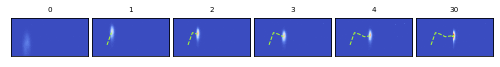

In [44]:
def plot_screens(df):
    df = df.copy()
    fig, ax = plt.subplots(1, 6, figsize=(textwidth*inches_per_point,textwidth*inches_per_point/4))
        
    extent = np.array(ExperimentalArea()._segment.AREABSCR1.extent) * 1000
    for (i, sample), ax in zip(enumerate([0, 1, 2, 3, 4, 30]), ax):
        img = df.loc[sample,"beam_image"].copy()
        vmax = df.iloc[-1]["beam_image"].max()
        # img[img < 0.01*vmax] = np.nan
        ax.set_title(sample)
        ax.imshow(img, vmin=0, vmax=vmax, extent=extent, cmap="coolwarm", interpolation="none")
        history_color = "greenyellow"
        ax.plot(df.loc[:sample,"mu_x"]*1000, df.loc[:sample,"mu_y"]*1000, c=history_color, ls="--", lw=1)
        # if sample > 0:
        #     ax.arrow(
        #         (df.loc[sample-1,"mu_x"]) * 1000,
        #         (df.loc[sample-1,"mu_y"]) * 1000,
        #         (df.loc[sample,"mu_x"]-df.loc[sample-1,"mu_x"]) * 1000,
        #         (df.loc[sample,"mu_y"]-df.loc[sample-1,"mu_y"]) * 1000,
        #         color=history_color,
        #         head_width=0.1,
        #         length_includes_head=True
        #     )
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        # plt.grid(ls="--")
        ax.set_xlim(-2, 2)
        ax.set_ylim(-1, 1)
    fig.tight_layout(pad=0)
    
    return fig

plot_screens(df)
plt.savefig("plots/screens.pdf", dpi=300, bbox_inches="tight")
plt.savefig("plots/screens.png", dpi=300, bbox_inches="tight")
plt.show()

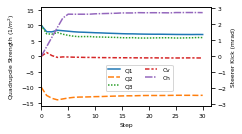

In [45]:
def plot_actuators(df):
    df = df.copy()
    fig, ax0 = plt.subplots(figsize=(0.45*textwidth*inches_per_point,0.45*0.6*textwidth*inches_per_point))

    df.rename(columns={"step": "Step"}, inplace=True)
    sns.lineplot(data=df.set_index("Step")[["q1","q2","q3"]], legend=False, ax=ax0)
    # for step in [0, 1, 2, 3, 4, 30]:
    #     ax0.axvline(step, c="tab:gray", alpha=0.4, lw=1)
    ax0.set_axisbelow(True)
    ax0.set_xlim(0, None)
    ax0.set_ylim(-16, 16)
    ax0.set_ylabel("Quadrupole Strength ($1/m^2$)")
    ax1 = plt.twinx()
    df["Q1"] = np.nan
    df["Q2"] = np.nan
    df["Q3"] = np.nan
    df[["cv","ch"]] *= 1000
    df.rename(columns={"cv": "Cv", "ch": "Ch"}, inplace=True)
    sns.lineplot(data=df.set_index("Step")[["Q1","Q2","Q3","Cv","Ch"]], ax=ax1)
    ax1.set_ylim(-3.1, 3.1)
    ax1.set_ylabel("Steerer Kick (mrad)")
    ax1.legend(loc=(0.38,0.15), ncol=2)
    return fig

plot_actuators(df)
plt.savefig("plots/actuators.pdf", dpi=300, bbox_inches="tight")
plt.savefig("plots/actuators.png", dpi=300, bbox_inches="tight")
plt.show()

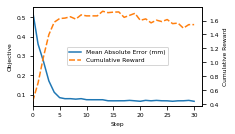

In [46]:
def plot_objective(df):
    df = df.copy()

    df.rename(columns={"step": "Step"}, inplace=True)
    df["Reward"] = df["reward"].apply(lambda x: float(x))
    df["Cumulative Reward"] = np.nan
    df["cumulative_reward"] = np.nan
    df.sort_index(inplace=True)
    for i in range(len(df)):
        df.loc[i,"cumulative_reward"] = df.loc[:i+1,"Reward"].sum()

    fig, ax0 = plt.subplots(figsize=(0.45*textwidth*inches_per_point,0.45*0.6*textwidth*inches_per_point))
    df["mae"] *= 1000
    df.rename(columns={"mae": "Mean Absolute Error (mm)"}, inplace=True)
    sns.lineplot(data=df.set_index("Step")[["Mean Absolute Error (mm)","Cumulative Reward"]], ax=ax0)
    # plt.grid(ls="--")
    ax0.set_xlim(0, None)
    ax0.set_ylabel("Objective")
    ax0.legend(loc="center")
    ax0.set_axisbelow(True)
    # for step in [0, 1, 2, 3, 4, 30]:
    #     ax0.axvline(step, c="tab:gray", alpha=0.4, lw=1)
    ax1 = plt.twinx()
    sns.lineplot(data=df.set_index("Step")[["Cumulative Reward","cumulative_reward"]], ax=ax1, legend=False)
    ax1.set_ylabel("Cumulative Reward")
    
    return fig

plot_objective(df)
plt.savefig("plots/objective_and_cumulative_reward.pdf", dpi=300, bbox_inches="tight")
plt.savefig("plots/objective_and_cumulative_reward.png", dpi=300, bbox_inches="tight")
plt.show()

In [3]:
dfopa = pd.read_pickle("machine_studies/summary_operatorsvsagents.pkl")

# Compute MAE
dfopa["delta_mu_x"] = np.abs(dfopa["mup_x"] - dfopa["mu_x"])
dfopa["delta_mu_y"] = np.abs(dfopa["mup_y"] - dfopa["mu_y"])
dfopa["delta_sigma_x"] = np.abs(dfopa["sigmap_x"] - dfopa["sigma_x"])
dfopa["delta_sigma_y"] = np.abs(dfopa["sigmap_y"] - dfopa["sigma_y"])
dfopa["mae"] = (dfopa["delta_mu_x"] + dfopa["delta_mu_y"] + dfopa["delta_sigma_x"] + dfopa["delta_sigma_y"]) / 4

In [4]:
hannes = dfopa[dfopa["model"] == "Hannes"].set_index("step").loc[100:2700].reset_index()
hannes["step"] = hannes["step"] - 100
willi = dfopa[dfopa["model"] == "Willi"].set_index("step").loc[185:2500].reset_index()
willi["step"] = willi["step"] - 185

polished_donkey = dfopa[dfopa["model"] == "polished-donkey-996"].copy()
polar_lake = dfopa[dfopa["model"] == "polar-lake-997"].copy()
still_deluge = dfopa[dfopa["model"] == "still-deluge-998"].copy()

est_dtoper = 0.5
est_dtagent = 10

hannes["estimated_t"] = hannes["step"] * est_dtoper
willi["estimated_t"] = willi["step"] * est_dtoper
polished_donkey["estimated_t"] = polished_donkey["step"] * est_dtagent
polar_lake["estimated_t"] = polar_lake["step"] * est_dtagent
still_deluge["estimated_t"] = still_deluge["step"] * est_dtagent

hannes["model"] = "Operator 1"
willi["model"] = "Operator 2"
polished_donkey["model"] = "Agent 1"
polar_lake["model"] = "Agent 2"
still_deluge["model"] = "Agent 3"

dfopa2 = pd.concat([hannes, willi, polished_donkey, polar_lake, still_deluge], ignore_index=True)

dfopa2["Time (min)"] = dfopa2["estimated_t"] / 60

op1mae = dfopa2.loc[dfopa2["model"] == "Operator 1",["mae","Time (min)"]].set_index("Time (min)").rename(columns={"mae": "Operator 1"})
op2mae = dfopa2.loc[dfopa2["model"] == "Operator 2",["mae","Time (min)"]].set_index("Time (min)").rename(columns={"mae": "Operator 2"})
ag1mae = dfopa2.loc[dfopa2["model"] == "Agent 1",["mae","Time (min)"]].set_index("Time (min)").rename(columns={"mae": "Agent 1"})
ag2mae = dfopa2.loc[dfopa2["model"] == "Agent 2",["mae","Time (min)"]].set_index("Time (min)").rename(columns={"mae": "Agent 2"})
ag3mae = dfopa2.loc[dfopa2["model"] == "Agent 3",["mae","Time (min)"]].set_index("Time (min)").rename(columns={"mae": "Agent 3"})
opvsagmae = pd.concat([op1mae, op2mae, ag1mae, ag2mae, ag3mae], axis=1) * 1000

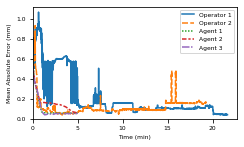

In [9]:
plt.figure(figsize=(0.5*textwidth*inches_per_point,0.5*0.6*textwidth*inches_per_point))
sns.lineplot(data=opvsagmae)
plt.xlim(0, None)
plt.ylim(0, None)
plt.ylabel("Mean Absolute Error (mm)")
plt.tight_layout()
plt.savefig("plots/operators_vs_agents_mae.pdf", dpi=300, bbox_inches="tight")
plt.savefig("plots/operators_vs_agents_mae.png", dpi=300, bbox_inches="tight")
plt.show()